# Stock Price Predicting with LSTM using Keras
                                                                                                                         --Yiqiao Chen

Neural Networks have been demonstrated to be very powerful in solving the real-world problems like imaging and natural language processing. Interested in stock price movements, I am therefore motivated and curious about employing nerual nets to approach financial time series problems of its kind.

Unlike common regression predictions, time series problems are more difficult due to sequence dependence within the input data variables. Among various neural nets, Long Short-Term Memory (***LSTM***), a type of recurrent neural network, has been proven to take care of complex time series predictions. So I implement LSTM to Amazon's stock prices (***AMZN***) using ***Keras***.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
from keras import backend as K
import math, time
import itertools
from math import sqrt

Using TensorFlow backend.
/Users/yiqiaochen/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
homeDir = "/Users/yiqiaochen/Desktop/stockPredictionUsingLSTM/"
stock = 'AMZN'

## 1. Load Data

Get up to five-year daily historical stock prices & volumes data from http://www.nasdaq.com/quotes/historical-quotes.aspx. 

Datasets consist of following columns:
- **date** Time stamp of when data was collected, being used as index column;
- **volume** The number of shares traded in AMZN during a given trading day;
- **open** The price at AMZN upon the opening of an exchange on a given trading day;
- **high** The highest price at which AMZN traded during the course of the day;
- **low** The lowest price at which AMZN traded during the course of the day;
- **close** The final price at which AMZN traded during the course of the day; it is also selected as our target data.

Plus, add a new feature based on the columns above:
- **pct** The percentage of change of close price compared to previous trading day.

In [3]:
rawdata = pd.read_csv(homeDir + 'Data/' + stock + '.csv')
## Reformat date
rawdata['date'] = [datetime.strptime(t, '%m/%d/%Y').strftime('%Y-%m-%d') for t in rawdata['date']]
## Sort date by date
rawdata.sort_values(by = 'date', ascending=True, inplace=True)
## Percentage Change
rawdata['pct'] = rawdata['close'].pct_change()
rawdata.dropna(inplace=True)
## Describe data
rawdata = rawdata[['date', 'volume', 'open', 'high', 'low', 'pct', 'close']]
rawdata.set_index('date', inplace=True)
print('Historical stock price data for', rawdata.shape[0], 'days')
print('from', rawdata.index[0], 'to', rawdata.index[rawdata.shape[0]-1])
rawdata.head()

Historical stock price data for 1217 days
from 2013-01-03 to 2017-10-31


,volume,open,high,low,pct,close
date,,,,,,
2013-01-03,2750470,257.27,260.880,256.370,0.004547,258.4800
2013-01-04,1874011,257.58,259.800,256.650,0.002592,259.1500
2013-01-07,4909389,262.97,269.725,262.670,0.035922,268.4592
2013-01-08,3008773,267.07,268.980,263.567,-0.007745,266.3800
2013-01-09,2262402,268.17,269.500,265.401,-0.000113,266.3500


#### Visualize the five-year daily close price data

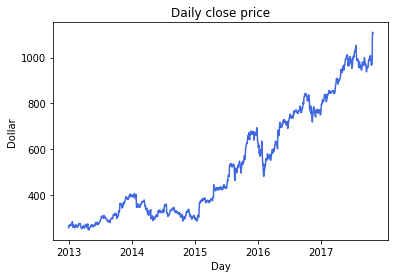

In [4]:
plt.plot(rawdata.index, rawdata['close'], color='royalblue')
plt.title('Daily close price')
plt.xlabel('Day')
plt.ylabel('Dollar')
plt.xticks([0, 252, 504, 756, 1008], ('2013', '2014', '2015', '2016', '2017') )
plt.show()

## 2. Data Preprocessing

### 2.1 Scale features

The input and output data that go into model need to be scaled. Use preprocessing.MinMaxScaler() function in scikit-learn library to scale data to the range of 0-1.

#### Scaled data

In [5]:
data=rawdata.copy()

In [6]:
min_max_scaler = preprocessing.MinMaxScaler()
data['volume'] = min_max_scaler.fit_transform(data['volume'].values.reshape(-1,1))
data['open'] = min_max_scaler.fit_transform(data['open'].values.reshape(-1,1))
data['high'] = min_max_scaler.fit_transform(data['high'].values.reshape(-1,1))
data['low'] = min_max_scaler.fit_transform(data['low'].values.reshape(-1,1))
data['pct'] = min_max_scaler.fit_transform(data['pct'].reshape(-1,1))
data['close'] = min_max_scaler.fit_transform(data['close'].values.reshape(-1,1))

data.head()

/Users/yiqiaochen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/yiqiaochen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


,volume,open,high,low,pct,close
date,,,,,,
2013-01-03,0.072845,0.009685,0.009139,0.012416,0.455738,0.011882
2013-01-04,0.034326,0.010046,0.007898,0.012743,0.447958,0.012659
2013-01-07,0.167727,0.016313,0.019308,0.019781,0.580597,0.023451
2013-01-08,0.084197,0.021080,0.018451,0.020830,0.406821,0.021041
2013-01-09,0.051395,0.022359,0.019049,0.022974,0.437194,0.021006


### 2.2 Split data to training set and test set

Split data into training (60%) and test sets (40%).

In [7]:
data = data.as_matrix()
df = []
for index in range(len(data) - 31):
    df.append(data[index: index + 31])
df = np.array(df)

In [8]:
splitRow = round(0.6 * df.shape[0])

## Training (60%)
train = df[:int(splitRow), :]
X_train = train[:, :-1] # all data until day 30
y_train = train[:, -1][:,-1] # day 31 close price
print('Training set:', train.shape[0], 'obs')

## Test (40%)
test = df[int(splitRow):, :]
X_test = test[:, :-1] # all data until day 30
y_test = test[:, -1][:,-1] # day 31 close price
print('Test set:', test.shape[0], 'obs')

Training set: 712 obs
Test set: 474 obs


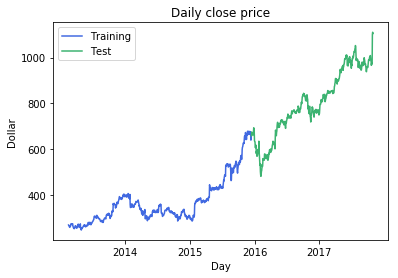

In [9]:
rawtrain = rawdata.iloc[31:743]
rawtest = rawdata.iloc[743:1217]
plt.plot(rawtrain.index, rawtrain['close'], color='royalblue', label='Training')
plt.plot(rawtest.index, rawtest['close'], color='mediumseagreen', label='Test')
plt.xticks([220, 473, 724, 976], ('2014', '2015', '2016', '2017'))
plt.legend(loc='upper left')
plt.title('Daily close price')
plt.xlabel('Day')
plt.ylabel('Dollar')
plt.show()

## 3. Modeling

Now predict the close price for day $m$ based on data observed in the past 30 days $\{m-30, m-29, ...m-1\}$.

### 3.1 Define Network

Define a **Sequential Model** and add:
- input layer with dimension (30, 6);
- two LSTM layers with 256 neurons;
- one hidden layers with 32 neurons with 'Relu';
- one linear output layer.

In [10]:
neurons = [256, 256, 32, 1]
shape = [30, 6, 1]
dropout = 0.3
decay = 0.5
epochs = 90

In [11]:
model = Sequential()

model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
model.add(Dropout(dropout))

model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
model.add(Dropout(dropout))

model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 256)           269312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 802,881
Trainable params: 802,881
Non-trainable params: 0
_________________________________________________________________


### 3.2 Compile Network

Before training, configure the learning process by specifying:

- **Optimizer** to be 'adam';

- **Loss function** to be 'mse';

- **Evaluation metric** to be 'accuracy'.

In [12]:
adam = keras.optimizers.Adam(decay=decay)
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

### 3.3 Train Network

Fit the model to training data to learn the parameters.


In [13]:
model.fit(X_train, y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.2,
    verbose=0)

### 3.4 Evaluate Network

Evaluate model on training set

In [14]:
mse, acc = model.evaluate(X_test, y_test)
print("mean square error = ", mse)

474/474 [==============================] - 1s 2ms/step
mean square error =  0.0111451563013


## 4. Results

The model shows that LSTM can capture the pattern of Amazon's stock prices. However, there are some gaps between predicted and true movements. We can certainly improve the performance by further tuning the model, but the assumption of the stable status in stock market mechanism makes it hard to get significantly better results. 

Since investor behavior is highly impacted by various factors, the future idea is to add sentiment analysis to better understand investors' pyschology. Therefore, we can capture more price catalysts in the market and achieve a better prediction with a holistic view. 

In [15]:
pred = model.predict(X_test)
pred = min_max_scaler.inverse_transform(pred)

y_test = y_test.reshape(-1, 1)
y_test = min_max_scaler.inverse_transform(y_test)

y_test = [i[0] for i in y_test]
pred = [i[0] for i in pred]

respred = rawtest.copy()
respred['close'] = pred

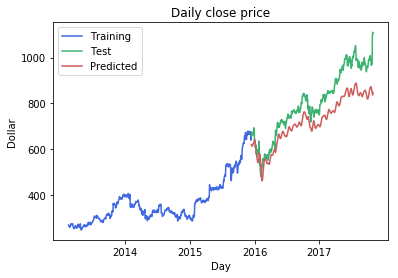

In [16]:
plt.plot(rawtrain.index, rawtrain['close'], color='royalblue', label='Training')
plt.plot(rawtest.index, rawtest['close'], color='mediumseagreen', label='Test')
plt.plot(rawtest.index, respred['close'], color='indianred', label='Predicted')
plt.xticks([220, 473, 724, 976], ('2014', '2015', '2016', '2017'))
plt.legend(loc='upper left')
plt.title('Daily close price')
plt.xlabel('Day')
plt.ylabel('Dollar')
plt.show()

In [17]:
from IPython.display import display_html
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)

Toggle Code